In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("PhishingDetection") \
    .getOrCreate()

# Load the CSV data into a Spark DataFrame
data_path = '/content/drive/MyDrive/School/Scalable/Project/sales_data_sample.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show schema and first few rows
df.printSchema()
df.show(5)


root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

In [7]:
from pyspark.sql.functions import (
    to_date, year, month, dayofmonth, dayofweek, quarter, weekofyear,
    countDistinct, count, sum as _sum, avg, min as _min, max as _max
)

def generate_analysis_report(df):
    print("📊 === Sales Data Statistical Analysis Report ===\n")

    # Ensure ORDERDATE is in DateType
    df = df.withColumn("ORDERDATE", to_date("ORDERDATE", "M/d/yyyy H:mm"))

    # Time features
    df = df.withColumn("ORDER_YEAR", year("ORDERDATE")) \
           .withColumn("ORDER_MONTH", month("ORDERDATE")) \
           .withColumn("ORDER_DAY", dayofmonth("ORDERDATE")) \
           .withColumn("ORDER_WEEKDAY", dayofweek("ORDERDATE")) \
           .withColumn("ORDER_QUARTER", quarter("ORDERDATE")) \
           .withColumn("ORDER_WEEK", weekofyear("ORDERDATE"))

    # Basic stats
    record_count = df.count()
    column_count = len(df.columns)

    print(f"🔹 Total Records: {record_count}")
    print(f"🔹 Total Columns: {column_count}")

    # Sales stats
    sales_summary = df.select(
        _sum("SALES").alias("TOTAL_SALES"),
        avg("SALES").alias("AVG_SALES"),
        _min("SALES").alias("MIN_SALES"),
        _max("SALES").alias("MAX_SALES")
    ).collect()[0]

    print("\n💰 Sales Summary:")
    print(f"   • Total Sales     : {sales_summary['TOTAL_SALES']:.2f}")
    print(f"   • Average Sales   : {sales_summary['AVG_SALES']:.2f}")
    print(f"   • Min Sale Amount : {sales_summary['MIN_SALES']:.2f}")
    print(f"   • Max Sale Amount : {sales_summary['MAX_SALES']:.2f}")

    # Time distribution
    print("\n🕒 Order Distribution by Month:")
    month_dist = df.groupBy("ORDER_MONTH").count().orderBy("ORDER_MONTH")
    for row in month_dist.collect():
        print(f"   • Month {row['ORDER_MONTH']:>2}: {row['count']} orders")

    # Deal Size analysis
    print("\n📦 Deal Size Distribution:")
    deal_stats = df.groupBy("DEALSIZE").agg(
        count("*").alias("num_orders"),
        _sum("SALES").alias("total_sales")
    ).orderBy("DEALSIZE")
    for row in deal_stats.collect():
        print(f"   • {row['DEALSIZE']:>6}: {row['num_orders']} orders, ${row['total_sales']:.2f} total")

    # Top countries by sales
    print("\n🌍 Top Countries by Total Sales:")
    country_sales = df.groupBy("COUNTRY").agg(_sum("SALES").alias("total_sales")) \
                      .orderBy("total_sales", ascending=False).limit(5)
    for row in country_sales.collect():
        print(f"   • {row['COUNTRY']:>10}: ${row['total_sales']:.2f}")

    # Top customers by number of orders
    print("\n👥 Top Customers by Order Count:")
    customer_orders = df.groupBy("CUSTOMERNAME").agg(countDistinct("ORDERNUMBER").alias("orders")) \
                        .orderBy("orders", ascending=False).limit(5)
    for row in customer_orders.collect():
        print(f"   • {row['CUSTOMERNAME'][:25]:<25}: {row['orders']} orders")

    # Top products by sales
    print("\n🛒 Top Products by Total Sales:")
    product_sales = df.groupBy("PRODUCTCODE").agg(_sum("SALES").alias("total_sales")) \
                      .orderBy("total_sales", ascending=False).limit(5)
    for row in product_sales.collect():
        print(f"   • {row['PRODUCTCODE']:>10}: ${row['total_sales']:.2f}")

    print("\n✅ Report complete.\n")

generate_analysis_report(df)

📊 === Sales Data Statistical Analysis Report ===

🔹 Total Records: 2823
🔹 Total Columns: 31

💰 Sales Summary:
   • Total Sales     : 10032628.85
   • Average Sales   : 3553.89
   • Min Sale Amount : 482.13
   • Max Sale Amount : 14082.80

🕒 Order Distribution by Month:
   • Month  1: 229 orders
   • Month  2: 224 orders
   • Month  3: 212 orders
   • Month  4: 178 orders
   • Month  5: 252 orders
   • Month  6: 131 orders
   • Month  7: 141 orders
   • Month  8: 191 orders
   • Month  9: 171 orders
   • Month 10: 317 orders
   • Month 11: 597 orders
   • Month 12: 180 orders

📦 Deal Size Distribution:
   •  Large: 157 orders, $1302119.26 total
   • Medium: 1384 orders, $6087432.24 total
   •  Small: 1282 orders, $2643077.35 total

🌍 Top Countries by Total Sales:
   •        USA: $3627982.83
   •      Spain: $1215686.92
   •     France: $1110916.52
   •  Australia: $630623.10
   •         UK: $478880.46

👥 Top Customers by Order Count:
   • Euro Shopping Channel    : 26 orders
   • Mini

In [8]:
from pyspark.sql.functions import (
    countDistinct, count, sum as _sum, avg, min as _min, max as _max
)

def generate_customer_analysis(df):
    print("👥 === Customer Analysis Report ===\n")

    # Compute customer-level aggregations
    customer_stats = df.groupBy("CUSTOMERNAME").agg(
        countDistinct("ORDERNUMBER").alias("NUM_ORDERS"),
        count("*").alias("NUM_ORDER_LINES"),
        countDistinct("PRODUCTCODE").alias("NUM_PRODUCTS_ORDERED"),
        _sum("SALES").alias("TOTAL_SALES"),
        avg("SALES").alias("AVG_SALES"),
        _min("SALES").alias("MIN_SALES"),
        _max("SALES").alias("MAX_SALES")
    )

    total_customers = customer_stats.count()
    print(f"🔸 Total Customers: {total_customers}\n")

    # Top customers by total sales
    print("💰 Top 5 Customers by Total Sales:")
    top_sales = customer_stats.orderBy("TOTAL_SALES", ascending=False).limit(5).collect()
    for row in top_sales:
        print(f"   • {row['CUSTOMERNAME'][:25]:<25}: ${row['TOTAL_SALES']:.2f} total sales")

    # Top customers by number of orders
    print("\n📦 Top 5 Customers by Number of Orders:")
    top_orders = customer_stats.orderBy("NUM_ORDERS", ascending=False).limit(5).collect()
    for row in top_orders:
        print(f"   • {row['CUSTOMERNAME'][:25]:<25}: {row['NUM_ORDERS']} orders")

    # Top customers by product variety
    print("\n🛒 Top 5 Customers by Product Variety:")
    top_products = customer_stats.orderBy("NUM_PRODUCTS_ORDERED", ascending=False).limit(5).collect()
    for row in top_products:
        print(f"   • {row['CUSTOMERNAME'][:25]:<25}: {row['NUM_PRODUCTS_ORDERED']} distinct products")

    print("\n✅ Customer analysis complete.\n")
generate_customer_analysis(df)

👥 === Customer Analysis Report ===

🔸 Total Customers: 92

💰 Top 5 Customers by Total Sales:
   • Euro Shopping Channel    : $912294.11 total sales
   • Mini Gifts Distributors L: $654858.06 total sales
   • Australian Collectors, Co: $200995.41 total sales
   • Muscle Machine Inc       : $197736.94 total sales
   • La Rochelle Gifts        : $180124.90 total sales

📦 Top 5 Customers by Number of Orders:
   • Euro Shopping Channel    : 26 orders
   • Mini Gifts Distributors L: 17 orders
   • Reims Collectables       : 5 orders
   • Australian Collectors, Co: 5 orders
   • Danish Wholesale Imports : 5 orders

🛒 Top 5 Customers by Product Variety:
   • Euro Shopping Channel    : 106 distinct products
   • Mini Gifts Distributors L: 77 distinct products
   • Souveniers And Things Co.: 44 distinct products
   • La Rochelle Gifts        : 43 distinct products
   • Land of Toys Inc.        : 41 distinct products

✅ Customer analysis complete.



In [9]:
from pyspark.sql.functions import sum as _sum, avg

def generate_product_analysis(df):
    print("📦 === Product Analysis Report ===\n")

    # Group by product and product line
    product_stats = df.groupBy("PRODUCTCODE", "PRODUCTLINE").agg(
        _sum("QUANTITYORDERED").alias("TOTAL_QUANTITY_SOLD"),
        _sum("SALES").alias("TOTAL_SALES"),
        avg("PRICEEACH").alias("AVG_UNIT_PRICE")
    )

    total_products = product_stats.count()
    print(f"🔸 Total Unique Products: {total_products}\n")

    # Top 5 best-selling products by sales
    print("💰 Top 5 Products by Total Sales:")
    top_sales = product_stats.orderBy("TOTAL_SALES", ascending=False).limit(5).collect()
    for row in top_sales:
        print(f"   • {row['PRODUCTCODE']:>10} ({row['PRODUCTLINE']:<15}): "
              f"${row['TOTAL_SALES']:.2f}, {row['TOTAL_QUANTITY_SOLD']} units, "
              f"avg price ${row['AVG_UNIT_PRICE']:.2f}")

    # Top 5 products by quantity sold
    print("\n📈 Top 5 Products by Quantity Sold:")
    top_qty = product_stats.orderBy("TOTAL_QUANTITY_SOLD", ascending=False).limit(5).collect()
    for row in top_qty:
        print(f"   • {row['PRODUCTCODE']:>10} ({row['PRODUCTLINE']:<15}): "
              f"{row['TOTAL_QUANTITY_SOLD']} units, "
              f"${row['TOTAL_SALES']:.2f} total, "
              f"avg price ${row['AVG_UNIT_PRICE']:.2f}")

    print("\n✅ Product analysis complete.\n")
generate_product_analysis(df)

📦 === Product Analysis Report ===

🔸 Total Unique Products: 109

💰 Top 5 Products by Total Sales:
   •   S18_3232 (Classic Cars   ): $288245.42, 1774 units, avg price $99.05
   •   S10_1949 (Classic Cars   ): $191073.03, 961 units, avg price $100.00
   •   S10_4698 (Motorcycles    ): $170401.07, 921 units, avg price $98.59
   •   S12_1108 (Classic Cars   ): $168585.32, 973 units, avg price $93.95
   •   S18_2238 (Classic Cars   ): $154623.95, 966 units, avg price $99.56

📈 Top 5 Products by Quantity Sold:
   •   S18_3232 (Classic Cars   ): 1774 units, $288245.42 total, avg price $99.05
   •   S24_3856 (Classic Cars   ): 1052 units, $140626.90 total, avg price $98.07
   •   S18_4600 (Trucks and Buses): 1031 units, $123723.08 total, avg price $98.37
   •  S700_4002 (Planes         ): 1029 units, $76175.63 total, avg price $73.62
   •   S12_4473 (Trucks and Buses): 1024 units, $115881.94 total, avg price $93.39

✅ Product analysis complete.



In [10]:
from pyspark.sql.functions import sum as _sum

def analyze_revenue_by_deal_and_territory(df):
    print("📦 Revenue by Deal Size:")
    revenue_by_deal = df.groupBy("DEALSIZE").agg(_sum("SALES").alias("TOTAL_REVENUE"))
    for row in revenue_by_deal.collect():
        print(f"   • {row['DEALSIZE']:>6}: ${row['TOTAL_REVENUE']:.2f}")

    print("\n🌍 Revenue by Territory:")
    revenue_by_territory = df.groupBy("TERRITORY").agg(_sum("SALES").alias("TOTAL_REVENUE"))
    for row in revenue_by_territory.collect():
        territory = row['TERRITORY'] if row['TERRITORY'] else "Unknown"
        print(f"   • {territory:>10}: ${row['TOTAL_REVENUE']:.2f}")
analyze_revenue_by_deal_and_territory(df)

📦 Revenue by Deal Size:
   • Medium: $6087432.24
   •  Small: $2643077.35
   •  Large: $1302119.26

🌍 Revenue by Territory:
   •         NA: $3852061.39
   •       APAC: $746121.83
   •      Japan: $455173.22
   •       EMEA: $4979272.41


In [12]:
from pyspark.sql.functions import expr

from pyspark.sql.functions import expr, avg, min as _min, max as _max, sum as _sum

def generate_profit_analysis(df):
    print("💰 === Profit Analysis Report ===\n")

    # Add profit-related columns
    df = df.withColumn("UNIT_PROFIT", expr("MSRP - PRICEEACH")) \
           .withColumn("TOTAL_PROFIT", expr("(MSRP - PRICEEACH) * QUANTITYORDERED"))

    # Basic stats for unit profit
    unit_profit_stats = df.select(
        avg("UNIT_PROFIT").alias("AVG_UNIT_PROFIT"),
        _min("UNIT_PROFIT").alias("MIN_UNIT_PROFIT"),
        _max("UNIT_PROFIT").alias("MAX_UNIT_PROFIT")
    ).collect()[0]

    print("🔹 Unit Profit Summary:")
    print(f"   • Average Unit Profit : ${unit_profit_stats['AVG_UNIT_PROFIT']:.2f}")
    print(f"   • Min Unit Profit     : ${unit_profit_stats['MIN_UNIT_PROFIT']:.2f}")
    print(f"   • Max Unit Profit     : ${unit_profit_stats['MAX_UNIT_PROFIT']:.2f}")

    # Basic stats for total profit
    total_profit_stats = df.select(
        _sum("TOTAL_PROFIT").alias("TOTAL_PROFIT"),
        avg("TOTAL_PROFIT").alias("AVG_TOTAL_PROFIT"),
        _min("TOTAL_PROFIT").alias("MIN_TOTAL_PROFIT"),
        _max("TOTAL_PROFIT").alias("MAX_TOTAL_PROFIT")
    ).collect()[0]

    print("\n📦 Total Profit Summary:")
    print(f"   • Total Profit        : ${total_profit_stats['TOTAL_PROFIT']:.2f}")
    print(f"   • Average Line Profit : ${total_profit_stats['AVG_TOTAL_PROFIT']:.2f}")
    print(f"   • Min Line Profit     : ${total_profit_stats['MIN_TOTAL_PROFIT']:.2f}")
    print(f"   • Max Line Profit     : ${total_profit_stats['MAX_TOTAL_PROFIT']:.2f}")

    print("\n✅ Profit analysis complete.\n")

    return df  # return updated df with profit columns

generate_profit_analysis(df)

💰 === Profit Analysis Report ===

🔹 Unit Profit Summary:
   • Average Unit Profit : $17.06
   • Min Unit Profit     : $-67.00
   • Max Unit Profit     : $154.64

📦 Total Profit Summary:
   • Total Profit        : $1706455.21
   • Average Line Profit : $604.48
   • Min Line Profit     : $-3216.00
   • Max Line Profit     : $7422.72

✅ Profit analysis complete.



DataFrame[ORDERNUMBER: int, QUANTITYORDERED: int, PRICEEACH: double, ORDERLINENUMBER: int, SALES: double, ORDERDATE: date, STATUS: string, QTR_ID: int, MONTH_ID: int, YEAR_ID: int, PRODUCTLINE: string, MSRP: int, PRODUCTCODE: string, CUSTOMERNAME: string, PHONE: string, ADDRESSLINE1: string, ADDRESSLINE2: string, CITY: string, STATE: string, POSTALCODE: string, COUNTRY: string, TERRITORY: string, CONTACTLASTNAME: string, CONTACTFIRSTNAME: string, DEALSIZE: string, ORDER_YEAR: int, ORDER_MONTH: int, ORDER_DAY: int, ORDER_WEEKDAY: int, ORDER_WEEK: int, ORDER_QUARTER: int, UNIT_PROFIT: double, TOTAL_PROFIT: double]

In [13]:
from pyspark.sql.functions import sum as _sum, avg, min as _min, max as _max

def generate_country_sales_report(df):
    print("🌍 === Country-Level Sales Analysis Report ===\n")

    # Aggregate sales by country
    country_sales = df.groupBy("COUNTRY") \
                      .agg(_sum("SALES").alias("TOTAL_SALES")) \
                      .orderBy("TOTAL_SALES", ascending=False)

    # Basic stats
    total_countries = country_sales.count()
    top_countries = country_sales.limit(10).collect()
    full_summary = country_sales.select(
        _sum("TOTAL_SALES").alias("GLOBAL_SALES"),
        avg("TOTAL_SALES").alias("AVG_COUNTRY_SALES"),
        _min("TOTAL_SALES").alias("MIN_COUNTRY_SALES"),
        _max("TOTAL_SALES").alias("MAX_COUNTRY_SALES")
    ).collect()[0]

    print(f"🔹 Total Countries        : {total_countries}")
    print(f"🔹 Global Total Sales     : ${full_summary['GLOBAL_SALES']:.2f}")
    print(f"🔹 Average Country Sales  : ${full_summary['AVG_COUNTRY_SALES']:.2f}")
    print(f"🔹 Min Country Sales      : ${full_summary['MIN_COUNTRY_SALES']:.2f}")
    print(f"🔹 Max Country Sales      : ${full_summary['MAX_COUNTRY_SALES']:.2f}")

    print("\n🌟 Top 10 Countries by Sales:")
    for row in top_countries:
        print(f"   • {row['COUNTRY']:<15}: ${row['TOTAL_SALES']:.2f}")

    print("\n✅ Country sales analysis complete.\n")
generate_country_sales_report(df)

🌍 === Country-Level Sales Analysis Report ===

🔹 Total Countries        : 19
🔹 Global Total Sales     : $10032628.85
🔹 Average Country Sales  : $528033.10
🔹 Min Country Sales      : $57756.43
🔹 Max Country Sales      : $3627982.83

🌟 Top 10 Countries by Sales:
   • USA            : $3627982.83
   • Spain          : $1215686.92
   • France         : $1110916.52
   • Australia      : $630623.10
   • UK             : $478880.46
   • Italy          : $374674.31
   • Finland        : $329581.91
   • Norway         : $307463.70
   • Singapore      : $288488.41
   • Denmark        : $245637.15

✅ Country sales analysis complete.



In [18]:
import pandas as pd

# Try with 'latin1' encoding
df_pd = pd.read_csv('/content/drive/MyDrive/School/Scalable/Project/sales_data_sample.csv', encoding='latin1')
df_pd.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set seaborn style for better visuals
sns.set(style="whitegrid")


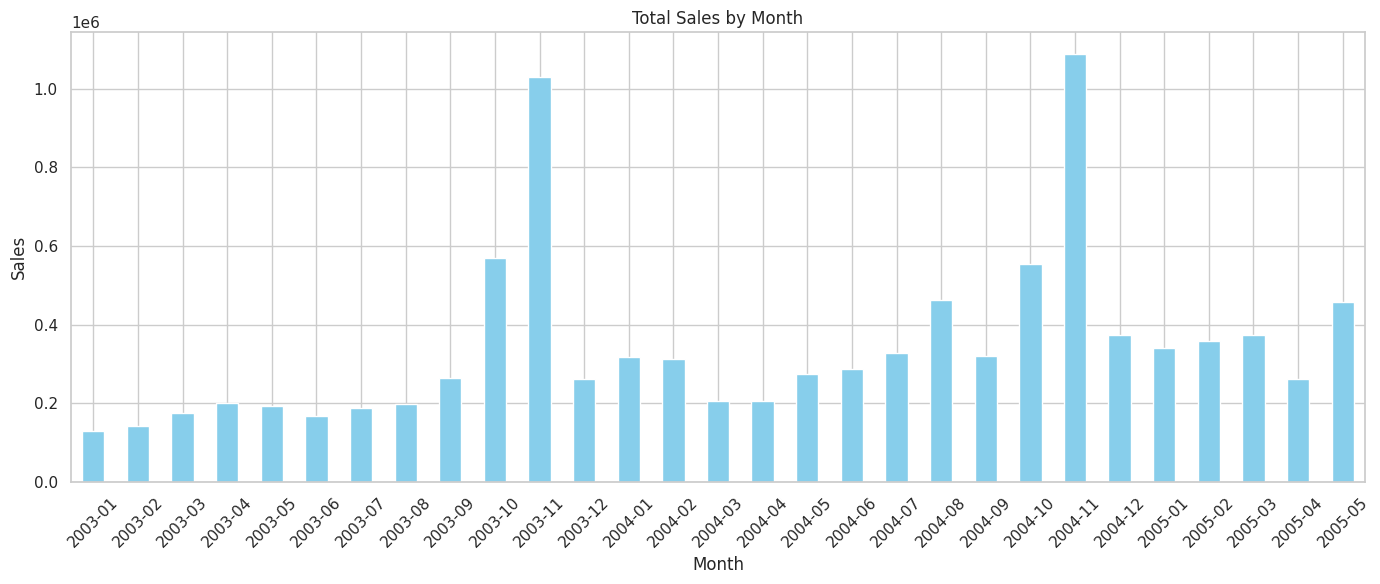

In [20]:
# Convert ORDERDATE to datetime
df_pd['ORDERDATE'] = pd.to_datetime(df_pd['ORDERDATE'])

# Group sales by month
monthly_sales = df_pd.groupby(df_pd['ORDERDATE'].dt.to_period('M'))['SALES'].sum()

# Plot
monthly_sales.plot(kind='bar', figsize=(14,6), color='skyblue')
plt.title('Total Sales by Month')
plt.ylabel('Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-21-362424082>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pd, x='DEALSIZE', palette='pastel')


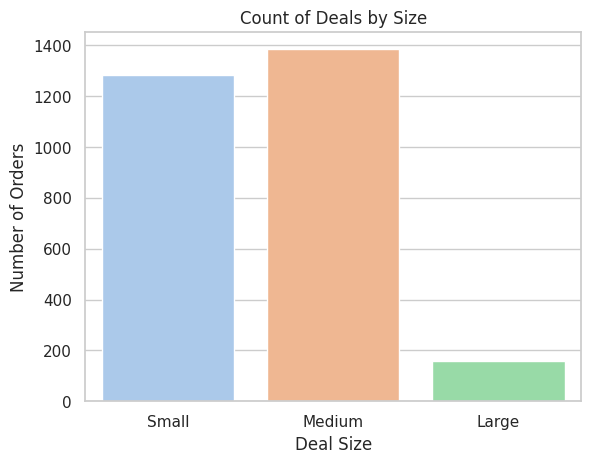

In [21]:
sns.countplot(data=df_pd, x='DEALSIZE', palette='pastel')
plt.title('Count of Deals by Size')
plt.xlabel('Deal Size')
plt.ylabel('Number of Orders')
plt.show()


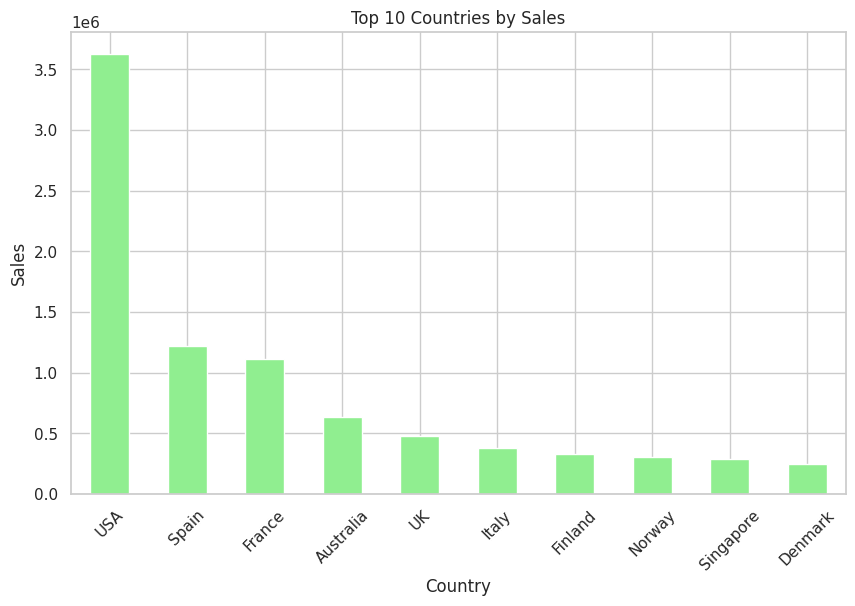

In [22]:
country_sales = df_pd.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False)

# Plot top 10 countries
country_sales.head(10).plot(kind='bar', figsize=(10,6), color='lightgreen')
plt.title('Top 10 Countries by Sales')
plt.ylabel('Sales')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()


<ipython-input-23-3548582852>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pd, x='DEALSIZE', y='PRICEEACH', palette='Set3')


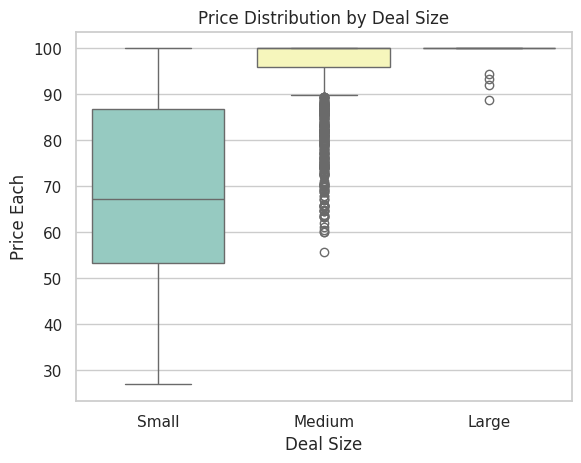

In [23]:
sns.boxplot(data=df_pd, x='DEALSIZE', y='PRICEEACH', palette='Set3')
plt.title('Price Distribution by Deal Size')
plt.xlabel('Deal Size')
plt.ylabel('Price Each')
plt.show()


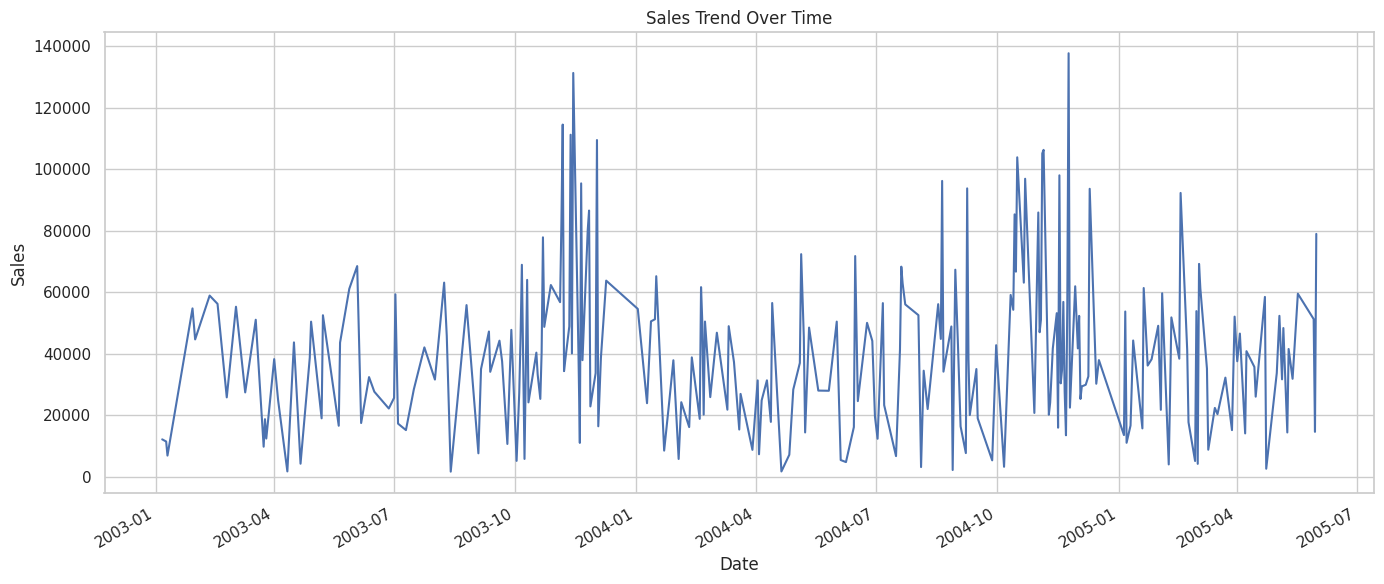

In [24]:
daily_sales = df_pd.groupby('ORDERDATE')['SALES'].sum()

# Plot
plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


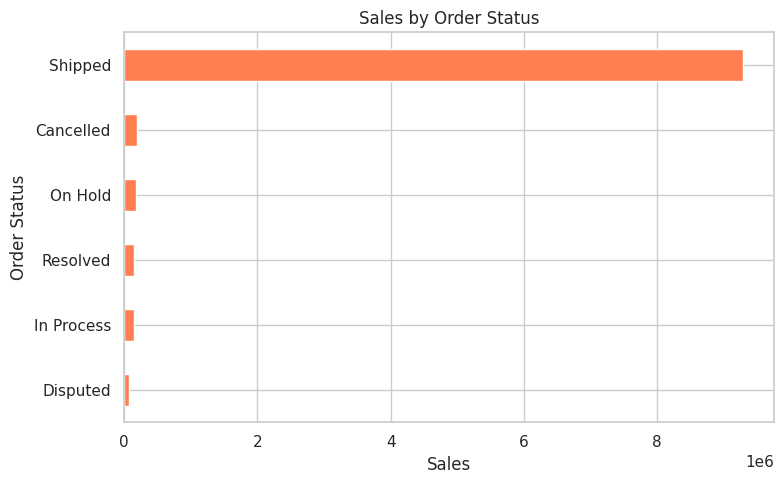

In [25]:
status_sales = df_pd.groupby('STATUS')['SALES'].sum().sort_values()

status_sales.plot(kind='barh', color='coral', figsize=(8,5))
plt.title('Sales by Order Status')
plt.xlabel('Sales')
plt.ylabel('Order Status')
plt.tight_layout()
plt.show()


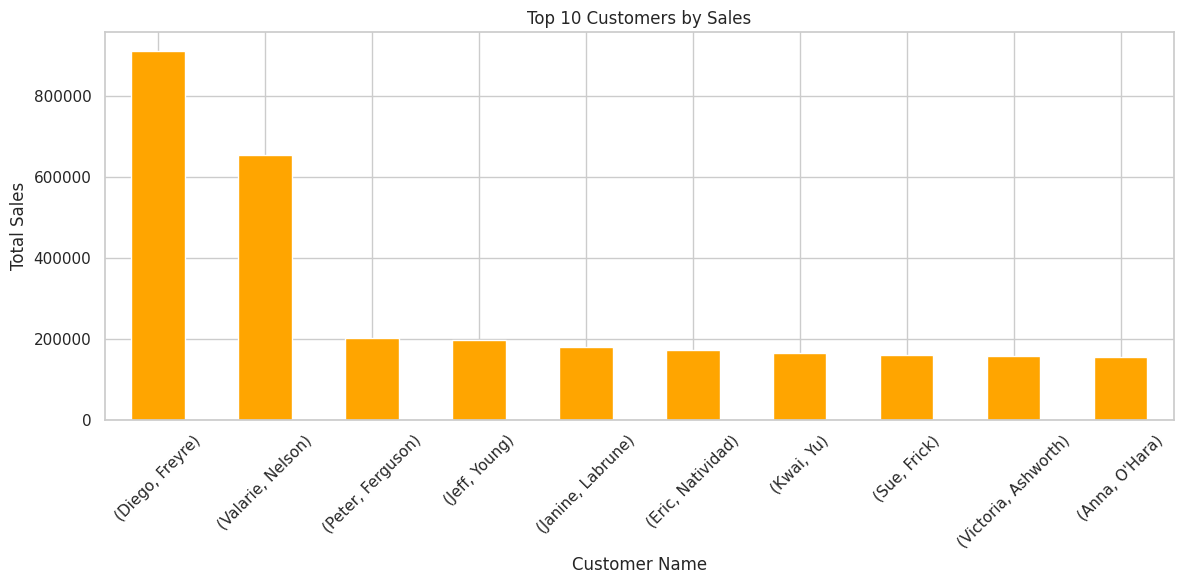

In [26]:
top_customers = df_pd.groupby(['CONTACTFIRSTNAME', 'CONTACTLASTNAME'])['SALES'].sum().sort_values(ascending=False).head(10)

top_customers.plot(kind='bar', figsize=(12,6), color='orange')
plt.title('Top 10 Customers by Sales')
plt.ylabel('Total Sales')
plt.xlabel('Customer Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


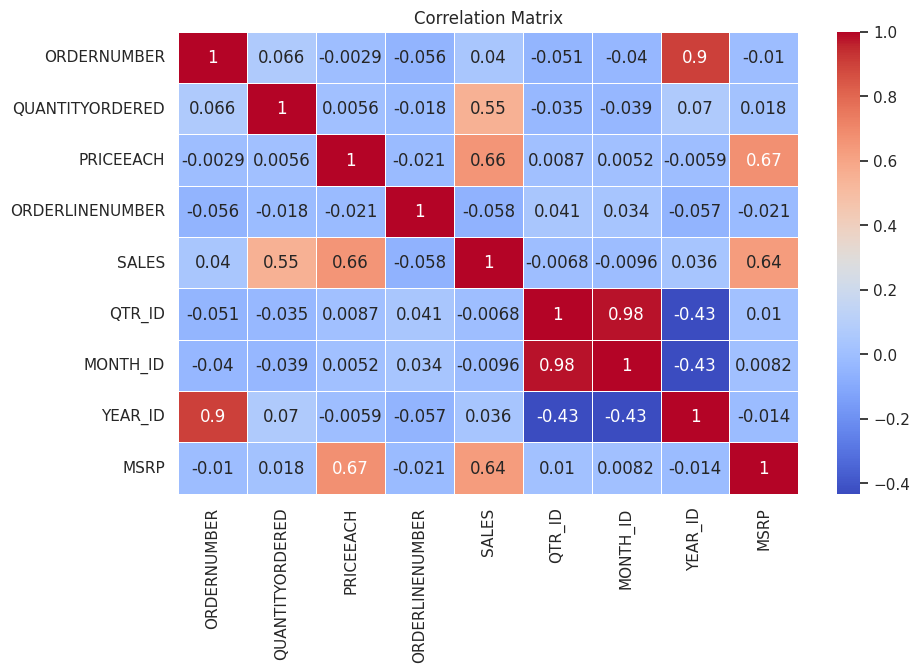

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_pd.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [32]:
import plotly.express as px

fig = px.scatter(df_pd, x='ORDERDATE', y='SALES',
                 color='DEALSIZE', size='QUANTITYORDERED',
                 hover_data=['COUNTRY', 'STATUS'])
fig.update_layout(title='Interactive Sales Explorer')
fig.show()
